In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import sys
import os

sys.path.insert(0, os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../backend"))
sys.path.append(os.path.abspath(""))

from sqlalchemy.orm import aliased, joinedload, selectinload, contains_eager
from rdflib.plugins.stores.sparqlstore import SPARQLStore
from backend.model import (
    DeclarativeBase,
    Session,
)

from backend.ontology import OntologyManager, OntologyConfig, Graph
from backend.explorative_support import TopicModelling, select
from backend.llm_query import (
    Entity,
    Relation,
    EntitiesRelations,
    EnrichedEntity,
    EnrichedRelation,
    EnrichedEntitiesRelations,
    SubjectLink,
    SubjectInDB,
    SubjectLinkDB,
)
from tqdm import tqdm
import pandas as pd

store = SPARQLStore(
    "http://localhost:7012/",
    method="POST_FORM",
    params={"infer": False, "sameAs": False},
)
graph = Graph(store=store)

config = OntologyConfig()

ontology_manager = OntologyManager(config, graph)
topic_man = TopicModelling(ontology_manager)

In [4]:
top_k = 100
seed = 42

In [5]:
from typing import TypeVar

SL = TypeVar("SL")


class EnrichedDBEntity(Entity, arbitrary_types_allowed=True):
    subject: SubjectInDB


class EnrichedDBRelation(Relation, arbitrary_types_allowed=True):
    link: SubjectLinkDB


def safe_prob(probs: np.array):
    if np.sum(probs) == 0:
        return np.ones(len(probs)) / len(probs)
    else:
        return probs / probs.sum()


def choose_entity(links: list[SL], rs: np.random.RandomState) -> SL:
    probs = np.array([link.instance_count for link in links])
    probs = safe_prob(probs)
    indices = np.arange(len(links))
    choice = rs.choice(indices, p=probs)
    return links[choice]


def random_downgrade(cls: SubjectInDB, rs: np.random.RandomState) -> SubjectInDB:
    def get_subclasses(subcls: SubjectInDB):
        subclasses = [subcls.sub_classes] + [
            get_subclasses(sub) for sub in subcls.sub_classes
        ]
        return [sub for sublist in subclasses for sub in sublist]

    # print(f"downgrading {cls.label}", [sc.label for sc in cls.sub_classes])
    subclasses = [cls] + get_subclasses(cls)
    probs = np.array([float(sc.instance_count) for sc in subclasses])
    probs = safe_prob(probs)
    # print(f"{cls.label} probs", probs)
    choice = rs.choice(np.arange(len(subclasses)), p=probs)
    return subclasses[choice]


def choose_graph(max_nodes=4, top_k=top_k, seed=seed):
    rs = np.random.RandomState(seed)
    with Session(topic_man.engine) as session:

        def downgrade_link_subjects(link: SubjectLinkDB):
            from_downgrade = random_downgrade(link.from_subject, rs)
            to_downgrade = random_downgrade(link.to_subject, rs)
            link.from_id = from_downgrade.subject_id
            link.to_id = to_downgrade.subject_id
            link.from_subject = from_downgrade
            link.to_subject = to_downgrade
            return link

        from_subject_alias = aliased(SubjectInDB, name="from_subject")
        to_subject_alias = aliased(SubjectInDB, name="to_subject")
        best_links_db = session.execute(
            select(SubjectLinkDB)
            .filter(SubjectLinkDB.from_id != SubjectLinkDB.to_id)
            .filter(SubjectLinkDB.to_id != None)
            .order_by(SubjectLinkDB.instance_count.desc())
            .join(
                from_subject_alias,
                SubjectLinkDB.from_subject.of_type(from_subject_alias),
            )
            .join(to_subject_alias, SubjectLinkDB.to_subject.of_type(to_subject_alias))
            # .options(
            #     lazyload(SubjectLinkDB.from_subject.of_type(from_subject_alias)),
            #     lazyload(SubjectLinkDB.to_subject.of_type(to_subject_alias)),
            # )
            .limit(top_k)
        ).all()
        best_links: list[SubjectLinkDB] = [link[0] for link in best_links_db]
        choice = choose_entity(best_links, rs)
        choice_downgraded = downgrade_link_subjects(choice)

        current_links = [
            (
                EnrichedDBRelation(
                    entity=choice_downgraded.from_subject.label,
                    relation=choice.label,
                    target=choice_downgraded.to_subject.label,
                    link=choice_downgraded,
                )
            )
        ]
        current_nodes = {
            subject.label: EnrichedDBEntity(
                identifier=subject.label,
                type=subject.label,
                subject=subject,
            )
            for subject in [
                choice_downgraded.from_subject,
                choice_downgraded.to_subject,
            ]
        }

        while len(current_nodes) < max_nodes:
            start_node = choose_entity(
                list([nd.subject for nd in current_nodes.values()]), rs
            )
            left_right = rs.choice([0, 1])
            extending_to = left_right == 0
            query = (
                select(SubjectLinkDB)
                .where(SubjectLinkDB.from_id != SubjectLinkDB.to_id)
                .where(SubjectLinkDB.to_id is not None)
                .join(
                    from_subject_alias,
                    SubjectLinkDB.from_subject.of_type(from_subject_alias),
                )
                .join(
                    to_subject_alias, SubjectLinkDB.to_subject.of_type(to_subject_alias)
                )
                .filter(
                    SubjectLinkDB.link_id.not_in(
                        [link.link.link_id for link in current_links]
                    )
                )
            )
            if extending_to:
                query = query.where(SubjectLinkDB.from_id == start_node.subject_id)
            else:
                query = query.where(SubjectLinkDB.to_id == start_node.subject_id)

            new_links = session.execute(
                query.order_by(SubjectLinkDB.instance_count.desc()).limit(top_k)
            ).all()
            new_links: list[SubjectLinkDB] = [link[0] for link in new_links]
            if len(new_links) == 0:
                continue
            choice = choose_entity(new_links, rs)

            extending_direction = (
                (choice.from_subject, choice.to_subject)
                if extending_to
                else (choice.to_subject, choice.from_subject)
            )

            downgraded_extend = random_downgrade(extending_direction[1], rs)
            print(
                "Downgraded from",
                extending_direction[1].label,
                downgraded_extend.label,
                "on link",
                choice.label,
            )
            if extending_to:
                choice_downgraded.to_id = downgraded_extend.subject_id
                choice_downgraded.to_subject = downgraded_extend
            else:
                choice_downgraded.from_id = downgraded_extend.subject_id
                choice_downgraded.from_subject = downgraded_extend
            if extending_to:
                current_links.append(
                    EnrichedDBRelation(
                        entity=choice.from_subject.label,
                        relation=choice.label,
                        target=choice_downgraded.to_subject.label,
                        link=choice_downgraded,
                    )
                )
            else:
                current_links.append(
                    EnrichedDBRelation(
                        entity=choice_downgraded.from_subject.label,
                        relation=choice.label,
                        target=choice.to_subject.label,
                        link=choice_downgraded,
                    )
                )
            current_nodes.update(
                {
                    subject.label: EnrichedDBEntity(
                        identifier=subject.label,
                        type=subject.label,
                        subject=subject,
                    )
                    for subject in [extending_direction[0], downgraded_extend]
                }
            )
        enriched_erl = EnrichedEntitiesRelations(
            entities=[
                EnrichedEntity(
                    subject=ontology_manager.enrich_subject(entity.subject.subject_id),
                    **entity.model_dump(exclude=["subject"]),
                )
                for entity in current_nodes.values()
            ],
            relations=[
                EnrichedRelation(
                    link=SubjectLink.from_db(relation.link, ontology_manager),
                    **relation.model_dump(exclude=["link"]),
                )
                for relation in current_links
            ],
        )
        return enriched_erl


erl = choose_graph(seed=33, max_nodes=10)

Downgraded from educational institution school on link alma mater
Downgraded from broadcaster radio station on link broadcast area
Downgraded from person athlete on link leader name
Downgraded from military service military service on link military service
Downgraded from work album on link auteur
Downgraded from river river on link mouth place
Downgraded from career station career station on link career station
Downgraded from person Sports team member on link career station


In [6]:
[(link.entity, link.relation, link.target) for link in erl.relations]

[('person', 'birth place', 'populated place'),
 ('person', 'alma mater', 'school'),
 ('radio station', 'broadcast area', 'populated place'),
 ('populated place', 'leader name', 'athlete'),
 ('person', 'military service', 'military service'),
 ('album', 'auteur', 'person'),
 ('river', 'mouth place', 'populated place'),
 ('person', 'career station', 'career station'),
 ('Sports team member', 'career station', 'career station')]

In [7]:
erl.entities[0].model_dump_json()

'{"identifier":"person","type":"person","constraints":[],"subject":{"subject_id":"<http://dbpedia.org/ontology/Person>","label":"person","spos":{"rdfs:label":{"property":"rdfs:label","label":null,"values":[{"value":"person","label":null}]},"rdfs:subClassOf":{"property":"rdfs:subClassOf","label":null,"values":[{"value":"<http://dbpedia.org/ontology/Animal>","label":"animal"}]}},"subject_type":"class","refcount":0,"descendants":{},"total_descendants":0,"properties":{},"instance_count":1922501}}'

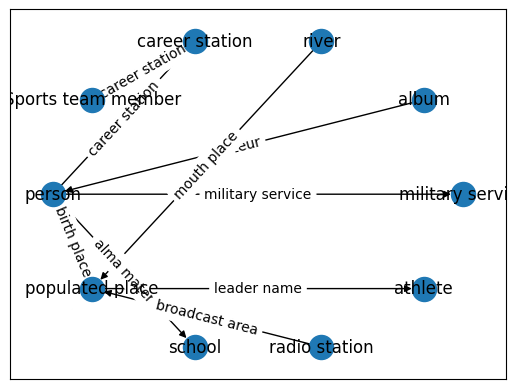

In [8]:
import networkx as nx


def viz_graph(erl: EnrichedEntitiesRelations):
    G = nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity, link.target, weight=link.link.instance_count, label=link.relation
        )
    pos = nx.shell_layout(G)
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels={node.identifier: node.type for node in erl.entities},
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(link.entity, link.target): link.relation for link in erl.relations}
    )
    return G


viz_graph(erl)

In [9]:
llama_model = topic_man.llama_model

llama_load_model_from_file: using device Metal (Apple M2 Pro) - 21845 MiB free
llama_model_loader: loaded meta data with 27 key-value pairs and 292 tensors from /Users/benedikt/.cache/huggingface/hub/models--NousResearch--Hermes-3-Llama-3.1-8B-GGUF/snapshots/307a5dfb59aa38d88b6cfd32f44b8ad7c1da9fb8/./Hermes-3-Llama-3.1-8B.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Hermes 3 Llama 3.1 8B
llama_model_loader: - kv   3:                       general.organization str              = NousResearch
llama_model_loader: - kv   4:                           general.basename str              = Hermes-3-Llama-3.1
llama_model_loa

In [10]:
messages = [
    {
        "role": "system",
        "content": """"You are a helpful assistant turning relational knowledge into natural language.""",
    },
    {
        "role": "user",
        "content": EntitiesRelations(
            entities=[
                Entity(
                    identifier="person 1",
                    type="person",
                ),
                Entity(
                    identifier="place 1",
                    type="place",
                ),
                Entity(
                    identifier="company 1",
                    type="person",
                ),
            ],
            relations=[
                Relation(
                    entity="company 1",
                    relation="employs",
                    target="person 1",
                ),
                Relation(
                    entity="person 1",
                    relation="residence",
                    target="place 1",
                ),
            ],
        ).model_dump_json(),
    },
    {
        "role": "assistant",
        "content": "a person is employed by a company and the same person resides in a place",
    },
]


In [11]:
response = llama_model.create_chat_completion(
    # grammar=self.grammar_erl,
    messages=messages + [
        {
            "role": "user",
            "content": erl.model_dump_json(),
        }
    ],
    max_tokens=-1,
    temperature=0.7,  # get wild :)
)


llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4906 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    81 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   29412.27 ms /  4987 tokens


In [12]:
response["choices"][0]["message"]["content"]

"a person's birthplace is a populated place, they attended a school, a radio station broadcasts in their area, a populated place is led by an athlete, the person served in military service, an album was created by the person, a river flows into a populated place, a person had a career station, a Sports team member had a career station, and a person is a subclass of an athlete."

In [ ]:
n_examples = 10
n_nodes = [3, 5, 10]
resulting_examples = []
progress = tqdm(total=n_examples * len(n_nodes))
for n_node in n_nodes:
    for i in range(n_examples):
        erl = choose_graph(seed=i, max_nodes=n_node)
        response = llama_model.create_chat_completion(
            # grammar=self.grammar_erl,
            messages=messages
            + [
                {
                    "role": "user",
                    "content": erl.model_dump_json(),
                }
            ],
            max_tokens=-1,
            temperature=0.7,  # get wild :)
        )
        progress.update(1)
        resulting_examples.append(
            {
                "erl": erl.model_dump_json(),
                "response": response["choices"][0]["message"]["content"],
                "n_nodes": n_node,
                "seed": i,
            }
        )
resulting_examples_df = pd.DataFrame(resulting_examples)
resulting_examples_df.to_csv("llama_examples.csv")

  0%|          | 0/30 [00:00<?, ?it/s]

Downgraded from organisation company on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1143 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1143 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4277.56 ms /  1154 tokens
  3%|▎         | 1/30 [00:04<02:22,  4.93s/it]

Downgraded from multi volume publication multi volume publication on link volumes


Llama.generate: 139 prefix-match hit, remaining 1152 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1152 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4446.65 ms /  1168 tokens
  7%|▋         | 2/30 [00:09<02:14,  4.81s/it]

Downgraded from person person on link auteur


Llama.generate: 139 prefix-match hit, remaining 1090 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1090 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4101.66 ms /  1102 tokens
 10%|█         | 3/30 [00:14<02:07,  4.71s/it]

Downgraded from organisation organisation on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1212 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1212 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4370.55 ms /  1224 tokens
 13%|█▎        | 4/30 [00:19<02:05,  4.84s/it]

Downgraded from Formula One racer Formula One racer on link first race


Llama.generate: 139 prefix-match hit, remaining 1206 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1206 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    68 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7467.94 ms /  1274 tokens
 17%|█▋        | 5/30 [00:27<02:30,  6.04s/it]

Downgraded from person function person function on link political leader


Llama.generate: 139 prefix-match hit, remaining 1120 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1120 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4513.06 ms /  1140 tokens
 20%|██        | 6/30 [00:32<02:17,  5.72s/it]

Downgraded from station station on link route end
Downgraded from station station on link route end
Downgraded from station station on link route junction
Downgraded from route of transportation road on link route junction


Llama.generate: 139 prefix-match hit, remaining 2207 prompt tokens to eval
llama_perf_context_print:        load time =   23630.37 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2207 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    40 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    9277.96 ms /  2247 tokens
 23%|██▎       | 7/30 [00:42<02:42,  7.05s/it]